#CS550 Project - Image Captioning

In [1]:
#Importing Necessary Libraries

from os import listdir
from pickle import dump
import tensorflow as tf
from zipfile import ZipFile
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications import vgg16
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# mount drive and check gpu
from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

Mounted at /content/drive


'/device:GPU:0'

In [3]:
# Function to extract features from each photo in the directory
from tqdm.notebook import tqdm
from time import sleep
def extract_features(directory,flag):

	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

	#print(model.summary())

	features = dict()
	i=0
	j=0
	k=len(listdir(directory))
	for name in listdir(directory):
		if j%1000==0:
			print(f'processoed {j} / {k} images')
		filename = directory + '/' + name
		image_ = load_img(filename, target_size=(224, 224))

		image = img_to_array(image_)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)

		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
		j+=1
		if flag :
				plt.figure()
				plt.imshow(image_)
				plt.show()
				print(f'Image Id:{image_id},Features :{vgg16.decode_predictions(feature, top=5)}')
	return features

In [4]:
file_name = "/content/drive/MyDrive/ML_Project/Images.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall("/content/Flicker8k")
  print('8K Dataset Loaded')

8K Dataset Loaded


In [5]:
file_name = "/content/drive/MyDrive/ML_Project/Images_30k.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall("/content/Flicker30k")
  print('30K Dataset Loaded')

30K Dataset Loaded


553467096/553467096 [==============================] - 2s 0us/step
processoed 0 / 3 images


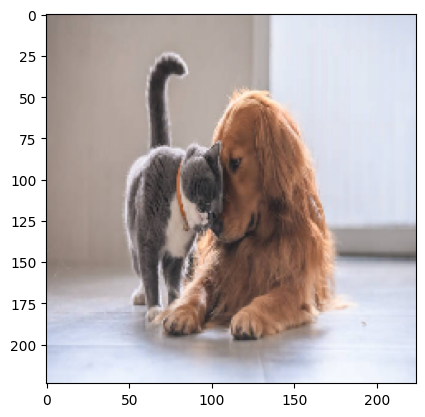

35363/35363 [==============================] - 0s 0us/step
Image Id:image,Features :[[('n02088094', 'Afghan_hound', 0.1536668), ('n02108551', 'Tibetan_mastiff', 0.15174058), ('n02088466', 'bloodhound', 0.1386951), ('n02102480', 'Sussex_spaniel', 0.13225384), ('n02102318', 'cocker_spaniel', 0.076138005)]]


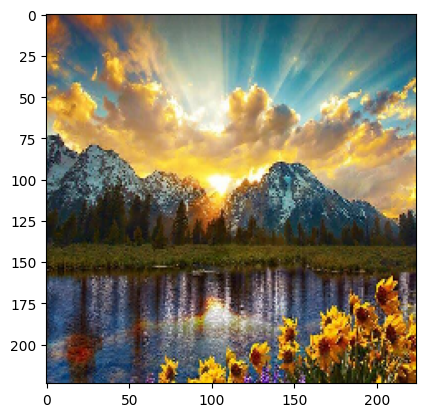

Image Id:image1,Features :[[('n09332890', 'lakeside', 0.48960283), ('n09468604', 'valley', 0.14229229), ('n09472597', 'volcano', 0.1075924), ('n03877845', 'palace', 0.033429798), ('n03457902', 'greenhouse', 0.031536773)]]


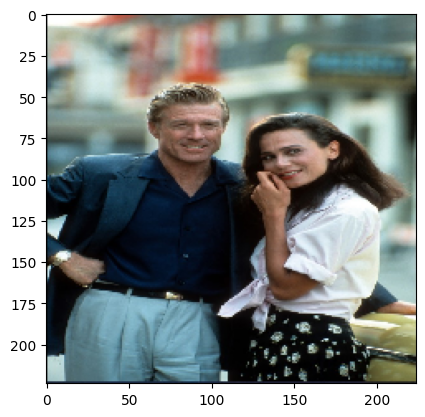

Image Id:image2,Features :[[('n03447447', 'gondola', 0.095315054), ('n03770439', 'miniskirt', 0.0682426), ('n03891251', 'park_bench', 0.045103107), ('n02992529', 'cellular_telephone', 0.031174747), ('n02883205', 'bow_tie', 0.02577815)]]


In [ ]:
directory = '/content/drive/MyDrive/ML_Project/test'
features = extract_features(directory,1)

In [ ]:
#Extracting features from the actual dataset

directory = '/content/Flicker8k'
features = extract_features(directory,0)
print('Extracted Features: %d' % len(features))

dump(features, open('features.pkl', 'wb'))

In [6]:
%cd '/content/drive/My Drive/ML_Project'
!cp 'features.pkl' '/content/'

/content/drive/My Drive/ML_Project


In [ ]:
#Extracting features from the actual dataset

directory = '/content/Flicker30k'
features = extract_features(directory,0)
print('Extracted Features: %d' % len(features))

dump(features, open('features_30k.pkl', 'wb'))

processoed 0 / 31783 images
processoed 1000 / 31783 images
processoed 2000 / 31783 images
processoed 3000 / 31783 images
processoed 4000 / 31783 images
processoed 5000 / 31783 images
processoed 6000 / 31783 images
processoed 7000 / 31783 images
processoed 8000 / 31783 images
processoed 9000 / 31783 images
processoed 10000 / 31783 images
processoed 11000 / 31783 images
processoed 12000 / 31783 images
processoed 13000 / 31783 images
processoed 14000 / 31783 images
processoed 15000 / 31783 images
processoed 16000 / 31783 images
processoed 17000 / 31783 images
processoed 18000 / 31783 images
processoed 19000 / 31783 images
processoed 20000 / 31783 images
processoed 21000 / 31783 images
processoed 22000 / 31783 images
processoed 23000 / 31783 images
processoed 24000 / 31783 images
processoed 25000 / 31783 images
processoed 26000 / 31783 images
processoed 27000 / 31783 images
processoed 28000 / 31783 images
processoed 29000 / 31783 images
processoed 30000 / 31783 images
processoed 31000 / 31

In [7]:
%cd '/content/drive/My Drive/ML_Project'
!cp 'features_30k.pkl' '/content/'
%cd '/content'

/content/drive/My Drive/ML_Project
/content


In [8]:
import string

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

def load_descriptions(doc,flag):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue

		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)

		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)

	return mapping

In [9]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]

			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)


def to_vocabulary(descriptions):
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [10]:
filename = '/content/drive/MyDrive/ML_Project/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc,0)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8680


In [11]:
filename = '/content/drive/MyDrive/ML_Project/captions_30k.txt'
doc = load_doc(filename)
descriptions_30k = load_descriptions(doc,0)
print('Loaded: %d ' % len(descriptions_30k))

clean_descriptions(descriptions_30k)
vocabulary_30k = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary_30k))

save_descriptions(descriptions_30k, 'descriptions_30k.txt')

Loaded: 31784 
Vocabulary Size: 8680


In [12]:
from pickle import load
from keras.preprocessing.text import Tokenizer

def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)


def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):

		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]

		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()

			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

def load_photo_features(filename, dataset):
	all_features = load(open(filename, 'rb'))
	features = {k: all_features[k] for k in dataset}
	return features

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [13]:
filename = '/content/drive/MyDrive/ML_Project/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# Define a function to calculate the maximum length of descriptions
def max_length(descriptions):
    return max(len(desc.split()) for desc_list in descriptions.values() for desc in desc_list)

max_len = max_length(train_descriptions)
print('Description Length: %d' % max_len)

train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)


print("Traning set loaded")

filename = '/content/drive/MyDrive/ML_Project/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
print("Test set loaded")

Dataset: 6000
Descriptions: train=6000
Description Length: 33
Photos: train=6000
Vocabulary Size: 7507
Traning set loaded
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
Test set loaded


In [26]:
filename = '/content/drive/MyDrive/ML_Project/Flickr_30k.trainImages.txt'
train_30k = load_set(filename)
print('Dataset: %d' % len(train_30k))

train_descriptions_30k = load_clean_descriptions('descriptions_30k.txt', train_30k)
print('Descriptions: train=%d' % len(train_descriptions_30k))

max_len_30k = max_length(train_descriptions_30k)
print('Description Length: %d' % max_len_30k)

train_features_30k = load_photo_features('features_30k.pkl', train_30k)
print('Photos: train=%d' % len(train_features_30k))

tokenizer_30k = create_tokenizer(train_descriptions_30k)
dump(tokenizer_30k, open('tokeniazer_30k.pkl', 'wb'))
vocab_size_30k = len(tokenizer_30k.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_30k)

print("Traning set loaded")

filename = '/content/drive/MyDrive/ML_Project/Flickr_30k.testImages.txt'
test_30k = load_set(filename)
print('Dataset: %d' % len(test_30k))
# descriptions
test_descriptions_30k = load_clean_descriptions('descriptions_30k.txt', test_30k)
print('Descriptions: test=%d' % len(test_descriptions_30k))
# photo features
test_features_30k = load_photo_features('features_30k.pkl', test_30k)
print('Photos: test=%d' % len(test_features_30k))
print("Test set loaded")

Dataset: 25427
Descriptions: train=25427
Description Length: 74
Photos: train=25427
Vocabulary Size: 17337
Traning set loaded
Dataset: 4054
Descriptions: test=4054
Photos: test=4054
Test set loaded


In [15]:
from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from keras.layers import concatenate
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [32]:
def create_sequences(token, max_length, desc_list, photo,vocab_size):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		seq = token.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

def define_model(vocab_size, max_length):

	inputs1 = Input(shape=(1000,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)

	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)

	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)

	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')

	#print(model.summary())
	return model

In [33]:
def data_generator(descriptions, photos, token, max_length,vocab_size):
	while 1:
		for key, desc_list in descriptions.items():
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(token, max_length, desc_list, photo,vocab_size)
			yield [[in_img, in_seq], out_word]

In [18]:
#model = define_model(vocab_size, max_len)
model = load_model('/content/drive/MyDrive/ML_Project/Models/model_19.h5')
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
	generator = data_generator(train_descriptions, train_features, tokenizer, max_len)
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	model.save('/content/drive/MyDrive/ML_Project/Models/model_' + str(20)+ '.h5')

6000/6000 [==============================] - 850s 140ms/step - loss: 2.6620


In [ ]:
model30 = define_model(vocab_size_30k, max_len_30k)
#model = load_model('/content/drive/MyDrive/ML_Project/Models/model_18.h5')
epochs = 1
steps1 = len(train_descriptions_30k)
for i in range(epochs):
	generator1 = data_generator(train_descriptions_30k, train_features_30k, tokenizer_30k, max_len_30k,vocab_size_30k)
	model30.fit_generator(generator1, epochs=1, steps_per_epoch=steps1, verbose=1)
	model30.save('/content/drive/MyDrive/ML_Project/Models/model30_' + str(i) + '.h5')

 1033/25427 [>.............................] - ETA: 2:02:46 - loss: 5.9463

In [ ]:
def generate_desc(model, tokenizer, photo, max_len):
	in_text = 'startseq'

	for i in range(max_len):

		sequence = tokenizer.texts_to_sequences([in_text])[0]
		sequence = pad_sequences([sequence], maxlen=max_len)
		yhat = model.predict([photo,sequence], verbose=0)
		yhat = argmax(yhat)
		word = word_for_id(yhat, tokenizer)
		if word is None:
			break
		in_text += ' ' + word
		if word == 'endseq':
			break
	return in_text

In [ ]:
# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())

	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
filename = '/content/drive/MyDrive/ML_Project/Models/model_10.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.542776
BLEU-2: 0.305591
BLEU-3: 0.217672
BLEU-4: 0.106817


In [ ]:
filename = '/content/drive/MyDrive/ML_Project/Models/model30_0.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions_30, test_features_30, tokenizer_30, max_length_30)

In [ ]:
tokenizer = load(open('tokeniazer.pkl', 'rb'))

max_length = 33
model = load_model('/content/drive/MyDrive/ML_Project/Models/model_19.h5')

def extract_feature(filename):
	model1 = VGG16()
	model1.layers.pop()
	model1 = Model(inputs=model1.inputs, outputs=model1.layers[-1].output)
	image = load_img(filename, target_size=(224, 224))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = model1.predict(image, verbose=0)
	return feature

photo = extract_feature('image1.jpg')
description = generate_desc(model, tokenizer, photo, max_length)

query = description
stopwords = ['startseq','endseq']
querywords = query.split()
resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

In [ ]:
!pip install evaluate
!pip install rouge-score
!pip install pillow

In [ ]:
from transformers import pipeline
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt

caption_generator = pipeline(model="ydshieh/vit-gpt2-coco-en")
directory = '/content/drive/MyDrive/ML_Project/test'

for name in listdir(directory):
    filename = directory + '/' + name
    print(filename)

    # Load the image using PIL
    image = Image.open(filename).resize((224, 224))

    # Display the image
    plt.figure()
    plt.imshow(image)
    plt.show()

    # Generate captions for the image
    captions = caption_generator(image)

    # Print the structure of the output
    #print(captions)

    # If the structure is a list of dictionaries, print the first one
    if captions and isinstance(captions[0], dict):
        print(f"Caption 1: {captions[0].get('generated_text', 'N/A')}")


In [ ]:
import evaluate
rouge = evaluate.load('rouge')
hypotheses = ['a group of people posing for a picture']
references = ['Four people posing for a picture']
results = rouge.compute(predictions=hypotheses, references=references)
print(results['rouge1'])

0.7142857142857143


In [ ]:
def average(lst):
    if not lst:
        return 0
    total = sum(lst)
    average = total / len(lst)
    return average

def evaluate_model_rogue(model,descriptions,photos,tokenizer,max_len):
  scores=[]
  i=0
  for key,desc_list in descriptions.items():
    yhat=generate_desc(model,tokenizer,photos[key],max_len)
    references =[d.split() for d in desc_list]
    #print(yhat,references)
    a=[]
    a.append(yhat)
    r=[]
    t=''
    for word in references[0]:
      t+=' '+word
    r.append(t)
    results = rouge.compute(predictions=a,references=r)
    scores.append(results['rouge1'])
    if i<10:
      print(a)
      print(r)
      print(results['rouge1'])
    i+=1
  print("Average score is: ",average(scores))

In [ ]:
filename = '/content/drive/MyDrive/ML_Project/Models/model_8.h5'
model = load_model(filename)
evaluate_model_rogue(model, test_descriptions, test_features, tokenizer, max_len)